# LSTM Language Modeling

In this example, we'll incorporate an LSTM that defines a language model into Nengo. We'll train the LSTM on the [Penn Treebank](https://catalog.ldc.upenn.edu/ldc99t42) (PTB) dataset, which is commonly used in the NLP community for developing language models (a bit like how MNIST is used as a starting point when building models for visual recognition tasks). The PTB dataset is also used in the Tensorflow's [NLP tutorials](https://www.tensorflow.org/tutorials/recurrent), which allows for a useful comparison of the differences between building a model into NengoDL versus defining it in Tensorflow alone. 

To provide some background, a [language model](https://en.wikipedia.org/wiki/Language_model) is a model that assigns probabilities to word sequences. We'll use an [Long Short-Term Memory](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (LSTM) network to do this. LSTM's are increasingly being used in a wide variety of state-of-the-art natural language processing systems, so they are good tool to be familiar with and make use of.

Finally, in contrast to the previous example illustrating how to incorporate a prebuilt Tensorflow model into Nengo, one purpose of this example is to explore the construction of a model that directly uses fairly low-level Tensorflow code.  

In [1]:
import os 
import nengo
import nengo_dl
import nengo.spa as spa 
import numpy as np
import tensorflow as tf

from urllib.request import urlretrieve
import zipfile

from ptb_lm import PTBModel
from helpers import has_punc

/Users/peterblouw/abr/nengo_dl/nengo_dl/__init__.py:19: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  warnings.warn("No GPU support detected. It is recommended that you "
/Users/peterblouw/abr/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.learning_rules.PES'>' already has a builder. Overwriting.
  % nengo_class)


## 1. Train an LSTM on the Penn Treebank dataset

We've included code for a simple LSTM model implemented in TensorFlow in this repository. With pure TensorFlow code, it is straightfoward to learn a set of parameters offline; we can then load the resulting parameters into a TensorNode that incorporates the learned LSTM function in a way that is consistent with Nengo's use of a real-time simulator. Specifically, we'll introduce some logic for allowing the TensorNode to selectively make use of the learned LSTM function based on both an externally provided control signal and the amount of simulation time that has passed. This setup will allow us to provide some sequence of input words to the TensorNode, and then predict an indefinite number of subsequent words. 

First, though, we'll download the Penn Treebank dataset and use the LSTM model to compute some perplexity values on both the training data and the validation data (to see how well our model is able to generalize).

In [2]:
dim = 300 # dimensionality of LSTM state

# download the Penn Treebank dataset (about 100mb unzipped) and pretrained model
def download(url, filename):
    urlretrieve(url, filename)
    with zipfile.ZipFile(filename) as f:
        f.extractall()
    
download("https://drive.google.com/uc?export=download&id=0BxRAh6Eg1us4VURvVmRrZ0Fmd3M", "ptb_data.zip")
download("https://drive.google.com/uc?export=download&id=0BxRAh6Eg1us4UkExX3NtcmpoR3c", "ptb_model.zip")
    
# set the path to the data and initialize the model
path = os.path.join(os.getcwd(), 'simple-examples/data')
model = PTBModel(path=path, dim=dim)

# either train the model (takes ~45 min) or load a saved model
do_training = False
if do_training:
    model.train(rate=rate, epochs=5, b_size=20, n_steps=15)
    model.save('ptb_model.ckpt')
else:
    model.load('ptb_model.ckpt')

INFO:tensorflow:Restoring parameters from ptb_model.ckpt


Now, we can compute the model's [perplexity](https://en.wikipedia.org/wiki/Perplexity) on the PTB dataset. This is essentially a numerical measure of how well the model is able to encode or capture the statistical regularities that are present in the data. Smaller perplexity values correspond to the model doing a better job of predicting these regularities.   

In [3]:
# will double-check that this is implemented correctly, skip for CI
if do_training:
    train_ppl = model.perplexity_eval(model.ptb['train_data'])
    valid_ppl = model.perplexity_eval(model.ptb['valid_data'])

    print('Perplexity on training dataset: ', train_ppl)
    print('Perplexity on validation dataset: ', valid_ppl)

Perplexity on training dataset:  60.8669789364
Perplexity on validation dataset:  184.198005616


These results suggest that we are overfitting (PTB is quite a small dataset), but that we have still learned a decent model.

## 2. Define a class for using the trained LSTM in Nengo

An LSTM can be thought of as a non-linear function that gets recursively applied over a sequence of inputs (i.e., at each step in the sequence, the function takes the current input and the previous state as its arguments). So, with that in mind, we can now define a class that will apply our learned LSTM function in the context of a Nengo model. 

To integrate this LSTM with a Nengo model, we'll create a list of variables that we want to load from the PTB model when 

In [4]:
# list the variables that we want to use from the trained LSTM in our TensorNode, then save in a checkpoint file
var_names = ['embedding_matrix', 'rnn/basic_lstm_cell/kernel','rnn/basic_lstm_cell/bias', 'b_softmax', 'W_softmax']
model.save_variables(var_names, 'lstm_params.ckpt')

Now we can define a callable class that contains the code that will implement our LSTM within a TensorNode.

In [5]:
class LSTM(object):
    # defines a function that can act as the callable in a TensorNode in a Nengo model
    def __init__(self, dim, vocab_size, update_interval=1):
        # initialize with the state dimensionality, vocabulary size, and update interval
        self.dim = dim
        self.vsize = vocab_size
        self.interval = update_interval
        
    def pre_build(self, *args):
        # define the core variables for providing input and making predictions with the LSTM
        self.embeddings = tf.Variable(tf.zeros([self.vsize, self.dim]), name='embedding_matrix')
        self.b_softmax = tf.Variable(tf.zeros(self.vsize), name='b_softmax')
        self.W_softmax = tf.Variable(tf.zeros([self.dim, self.vsize]), name='W_softmax')
        
        # cell and hidden state variables for LSTM, these get updated with each call
        self.c = tf.Variable(tf.zeros((1, self.dim)), tf.float32, name='state_c')
        self.h = tf.Variable(tf.zeros((1, self.dim)), tf.float32, name='state_h')
        self.state = tf.contrib.rnn.LSTMStateTuple(self.c, self.h)
        
        # define the LSTM object
        self.cell = tf.contrib.rnn.BasicLSTMCell(self.dim, state_is_tuple=True) 
        
        # variables for doing appropriate control flow
        self.cache = tf.Variable(0.0, name='cache')
        self.repval = tf.Variable(0.0, name='repval')

    def post_build(self, sess, rng):
        # restore only the needed variables from a pretrained LSTM
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        restoring = [v for v in variables for n in var_names if n in v.name] 
        saver = tf.train.Saver(restoring)
        saver.restore(sess, 'lstm_params.ckpt')

    def __call__(self, t, x):
        # two-dimensional input, first dimension is input word, second is control signal
        # (we are disregarding the axis of the input tensor corresponding to batch size)
        # if signal < 1, the input word is used; otherwise, the last prediction is used
        inp = x[0, 0]
        sig = x[0, 1]

        # functions define branches in comp graph that get selected via update interval
        # might be clearer/simpler to define these as static methods, not sure
        def update():
            # pick either input or cache to use for lookup, depending on control signal
            self.idx = tf.cond(sig < 1, lambda: inp, lambda: self.cache)
            self.idx = tf.cast(tf.reshape(self.idx, (1,1)), tf.int32)
            emb = tf.nn.embedding_lookup(self.embeddings, self.idx)
    
            # run the LSTM for one step using input embedding and current cell state
            outputs, next_state = tf.nn.dynamic_rnn(self.cell, emb, initial_state=self.state)
            outputs = tf.reshape(outputs, [-1, self.dim])
            
            # compute probability distribution over vocab and predict argmax 
            logits = tf.nn.xw_plus_b(outputs, self.W_softmax, self.b_softmax)
            probs = tf.nn.softmax(logits)
            prediction = tf.cast(tf.argmax(probs[0]), tf.float32)

            # update the LSTM cell state and the cache
            self.c = tf.assign(self.c, next_state.c)
            self.h = tf.assign(self.h, next_state.h)
            self.cache = tf.assign(self.cache, prediction) 
            
            # return the predicted item while requiring state assignments
            with tf.control_dependencies([self.c, self.h, self.cache]):
                return tf.reshape(prediction, (1, 1))
            
        def repeat():
            # return the most recently returned value 
            return tf.reshape(self.repval, (1, 1))
        
        # check whether current time is a multiple of the update clock
        check = tf.equal(tf.mod(tf.round(1000 * t), self.interval), 0)
        output = tf.cond(tf.cast(check, tf.bool), update, repeat)
        
        # save the output to return again during repeat calls
        self.repval = tf.assign(self.repval, output[0,0])
        
        # return the output while requiring repval assignment
        with tf.control_dependencies([self.repval]):
            return tf.reshape(output, (1,1))      

When an instance of this class is called, it will return an output based on whether it's input specifies an 'encoding' regime, or a 'prediction' regime. During encoding, the input is used to update the internal state of the LSTM; during prediction, the input is ignored, and the internal state is used to produce a new output with each call that involves updating the LSTM. (the update interval sets how frequently the LSTM actually updates in relation to the amount of time simulated in Nengo).  

## 3. Define a Nengo model

Now, everything is in place to build a model in Nengo that uses an LSTM to predict the next words in a sequence. Since we would like our LSTM outputs be semantic pointers corresponding to specific words (i.e., SPs that can be used for downstream tasks), we'll convert the PTB model vocabulary into a SPA vocabulary. We'll also define some functions for determining the behavior of nodes the provide a control signal and map to items in a SPA vocabulary, respectively.  

In [6]:
seed = 234
n_inputs = 6
update_interval = 25 # milliseconds between LSTM updates
vocab_size = model.ptb['vocabulary']

lstm_func = LSTM(dim, vocab_size, update_interval)

def control_signal(t, x):
    # return enc signal for time to provide n_inputs 
    if t < (update_interval * n_inputs + 1) / 1000.0:
        return 0
    # return prediction signal
    else:
        return 1

spa_vocab = model.build_spa_vocab(dim=64)
    
# for defining a node that maps from LSTM outputs to SPs
def vocab_lookup(t, x):
    word = model.id_to_word[int(x)]
    # check for words that can't be SP keys
    if has_punc(word):
        return spa_vocab['UNK'].v
    else:
        return spa_vocab[word.upper()].v

We'll create an array of word ids from a prompt to present to the model as input, and then create the model definition.

In [7]:
# select the input prompt to predict continuations for
prompt = 'trading stopped in the afternoon because'
ids = [model.word_to_id[w] for w in prompt.split()]
input_ids = np.reshape(np.array(ids), (len(ids), 1))
input_ids = np.vstack((input_ids, np.zeros((10, 1))))    
    
with nengo.Network(seed=seed) as net:
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    
    inp = nengo.Node(nengo.processes.PresentInput(input_ids, update_interval / 1000))
    sig = nengo.Node(control_signal, size_in=1, size_out=1)
    lstm = nengo_dl.TensorNode(lstm_func, size_in=2, size_out=1)
    
    ens = nengo.Ensemble(50 * spa_vocab.dimensions, spa_vocab.dimensions)
    cleanup = nengo.Node(vocab_lookup, size_in=1, size_out=spa_vocab.dimensions)

    nengo.Connection(inp, lstm[0])
    nengo.Connection(sig, lstm[1])
    nengo.Connection(lstm, cleanup)
    nengo.Connection(cleanup, ens)
    
    net.config[nengo.Probe].synapse = None
    inp_probe = nengo.Probe(inp)
    sig_probe = nengo.Probe(sig)
    lang_probe = nengo.Probe(lstm)
    clean_probe = nengo.Probe(cleanup)

## 4. Evaluate the model's output

We can now simulate our Nengo model for an arbitrary amount of time, and the LSTM we have incorporated with first encode the provided input, and then produce an indefinitely long continuation of this input. 

In [8]:
sim = nengo_dl.Simulator(net, seed=seed)
sim.run(0.5)

# indices for sampling the simulator output at update intervals
inp_idxs = range(0, n_inputs * update_interval, update_interval)
out_idxs = range(n_inputs * update_interval, 500, update_interval)

# Text representation of the output of the Nengo model 
print('Prompt: ', [model.id_to_word[i[0]] for i in sim.data[inp_probe][inp_idxs]])
print('Predicted continuation: ', [model.id_to_word[i[0]] for i in sim.data[lang_probe][out_idxs]])

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
INFO:tensorflow:Restoring parameters from lstm_params.ckpt
Simulation completed in 0:00:00
Prompt:  ['trading', 'stopped', 'in', 'the', 'afternoon', 'because']
Predicted continuation:  ['of', 'the', 'market', "'s", 'recent', 'weakness', 'in', 'the', 'dollar', '<eos>', 'the', 'dow', 'industrials', 'closed']


As is clear, the model's predicticted continuation contain plausible, well-formed sequences of words. To ensure that the model is performing as well as our basic tensorflow implementation, we can compare its predictions on the same input.  

In [9]:
print('Prompt: ', prompt)
print('Predicted continuation: ', model.predict(prompt, 14)[1])

Prompt:  trading stopped in the afternoon because
Predicted continuation:  ['of', 'the', 'market', "'s", 'recent', 'weakness', 'in', 'the', 'dollar', '<eos>', 'the', 'dow', 'industrials', 'closed']


As is apparent, Finally, we can plot a standard semantic graph of the outputs to visualize what our model is actually doing. 

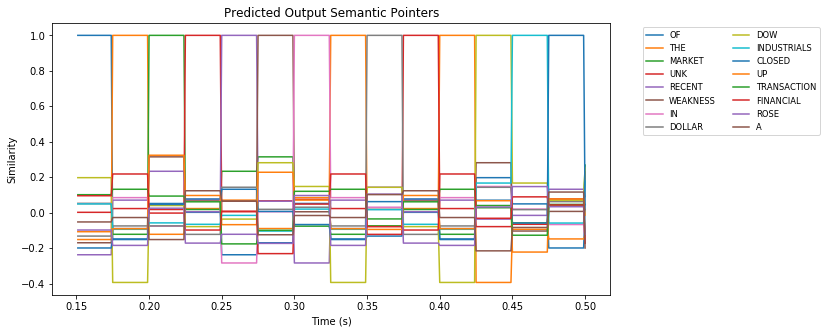

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# pick a subset of the vocab that include the predicted words
plot_vocab = spa_vocab.create_subset(['OF','THE','MARKET','UNK','RECENT','WEAKNESS','IN','DOLLAR','DOW',
                                      'INDUSTRIALS','CLOSED','UP','TRANSACTION','FINANCIAL','ROSE','A'])
plt.figure(figsize=(10, 5))
plt.title('Predicted Output Semantic Pointers')
plt.plot(sim.trange()[n_inputs*update_interval:], nengo.spa.similarity(sim.data[clean_probe][n_inputs*update_interval:], plot_vocab))
plt.legend(plot_vocab.keys, fontsize='small', bbox_to_anchor=(1.05, 1.0), ncol=2)
plt.xlabel("Time (s)")
plt.ylabel("Similarity");

TODO: Incorporate synapses in the model, refactor code, edit text, etc.